# Cargar datos

In [1]:
# Imports y configuración básica
import os
import math
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
FIG_DIR = Path("../reports/figures").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

In [2]:
# =============================================================================
# Configuración optimizada de la sesión de Spark
# =============================================================================
# Esta configuración es más robusta para conjuntos de datos grandes.
# Debe ejecutarse una vez al inicio del notebook.

from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("BlueBikes-Project") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

# Establecer variables de entorno para que PySpark funcione correctamente en algunos entornos
import sys
# os.environ["PYSPARK_PYTHON"] = sys.executable
# os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"

In [3]:
# =============================================================================
# Cargar DataFrame procesado desde Google Drive (para Colab)
# =============================================================================
# Esta celda activa tu Google Drive y lee los datos procesados del archivo Parquet almacenado allí.
# Usarlo en el entorno de Google Colab.

from google.colab import drive

print("Intentando montar Google Drive...")
try:
    drive.mount('/content/drive')

    gdrive_path = "/content/drive/MyDrive/BlueBikes_PRJ/df_final_bluebikes_v1.parquet/forecast_hourly_station_20250822_020019.parquet"
    print(f"Cargando datos desde la ruta de Google Drive: {gdrive_path}")

    # Spark leerá la carpeta Parquet directamente
    df = spark.read.parquet(gdrive_path)

    print("✅ DataFrame cargado exitosamente desde Google Drive.")

    # Verify the schema and show a few rows
    print("Esquema de DataFrame:")
    df.printSchema()

    print("Muestra de los datos cargados:")
    df.show(5, truncate=False)

except Exception as e:
    print(f"❌ Error al cargar datos desde Google Drive. Asegúrate de que el archivo exista en '{gdrive_path}'.")
    print(f"Detalles del error: {e}")

Intentando montar Google Drive...
Mounted at /content/drive
Cargando datos desde la ruta de Google Drive: /content/drive/MyDrive/BlueBikes_PRJ/df_final_bluebikes_v1.parquet/forecast_hourly_station_20250822_020019.parquet
✅ DataFrame cargado exitosamente desde Google Drive.
Esquema de DataFrame:
root
 |-- ts_hour: timestamp_ntz (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- rides: long (nullable = true)
 |-- trip_year: integer (nullable = true)
 |-- trip_month: integer (nullable = true)
 |-- trip_day_of_week: integer (nullable = true)
 |-- trip_hour: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- season: string (nullable = true)
 |-- avg_dur_sec: double (nullable = true)
 |-- median_dur_sec: long (nullable = true)
 |-- avg_speed_kmh: double (nullable = true)
 |-- km_total: double (nullable = true)
 |-- round_trips: long (nullable = true)
 |-- rides_member: long (nullable = true)
 |-- rides_ca

In [4]:
df = df.toPandas()

In [14]:
df

,ts_hour,start_station_name,rides,trip_year,trip_month,trip_day_of_week,trip_hour,is_weekend,is_holiday,season,avg_dur_sec,median_dur_sec,avg_speed_kmh,km_total,round_trips,rides_member,rides_casual,rides_classic,rides_electric
0,2024-04-29 10:00:00,Broadway and Cabot,2,2024,4,2,10,0,0,spring,955.000000,954,8.320807,4.413785,0,1,1,2,0
1,2024-05-02 14:00:00,Broadway and Cabot,1,2024,5,5,14,0,0,spring,182.000000,182,14.805980,0.748539,0,1,0,1,0
2,2024-05-03 08:00:00,Broadway and Cabot,1,2024,5,6,8,0,0,spring,3095.000000,3095,2.204383,1.895159,0,0,1,1,0
3,2024-05-04 04:00:00,Broadway and Cabot,1,2024,5,7,4,1,0,spring,1500.000000,1500,18.531265,7.721379,0,1,0,0,1
4,2024-05-05 04:00:00,Broadway and Cabot,1,2024,5,1,4,1,0,spring,1496.000000,1496,18.560137,7.712786,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9369031,2018-04-30 13:00:00,Yawkey Way at Boylston St.,2,2018,4,2,13,0,0,spring,750.000000,566,9.177663,3.832906,0,2,0,0,0
9369032,2018-04-30 14:00:00,Yawkey Way at Boylston St.,3,2018,4,2,14,0,0,spring,503.666667,445,8.914039,3.690916,0,3,0,0,0
9369033,2018-04-30 15:00:00,Yawkey Way at Boylston St.,2,2018,4,2,15,0,0,spring,1016.000000,928,10.739285,6.112997,0,2,0,0,0
9369034,2018-04-30 16:00:00,Yawkey Way at Boylston St.,2,2018,4,2,16,0,0,spring,390.000000,377,6.530764,1.413440,0,0,2,0,0


# Heatmap de Rides por Semana

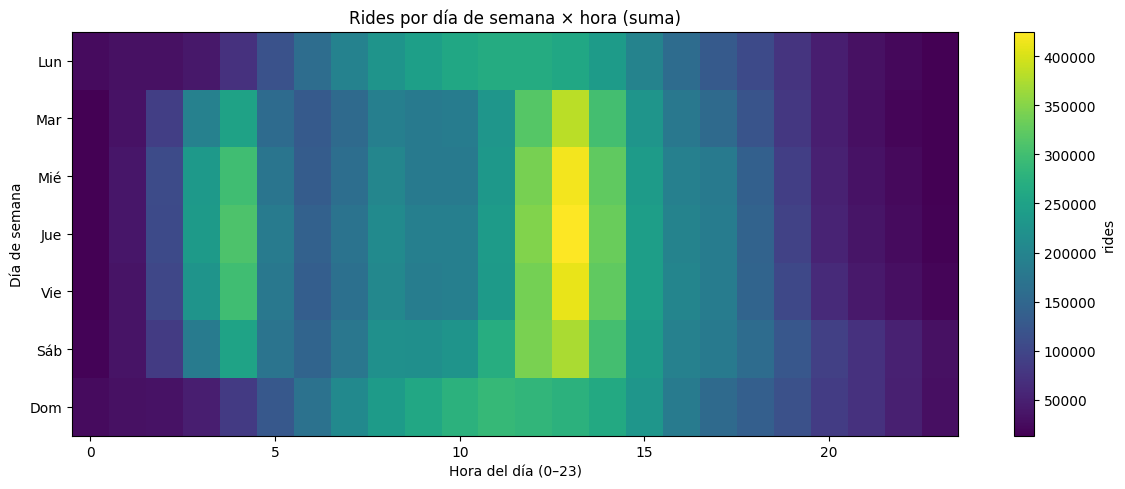

Guardado: /content/reports/figures/heatmap_rides_dow_hour.png


In [29]:
import matplotlib.pyplot as plt

# Asegurar que trip_day_of_week esté en 0–6 (Lun=0)
if df["trip_day_of_week"].min() == 1:
    # si está en 1–7, lo pasamos a 0–6
    df["trip_day_of_week"] = (df["trip_day_of_week"] - 1) % 7

# Construir matriz rides por día×hora
pivot = (
    df.groupby(["trip_day_of_week","trip_hour"])["rides"]
      .sum()
      .unstack(fill_value=0)
      .reindex(index=range(0,7), columns=range(0,24), fill_value=0)
)

# Mapa de etiquetas
dias = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]

plt.figure(figsize=(12,5))
plt.imshow(pivot.values, aspect="auto", cmap="viridis")
plt.title("Rides por día de semana × hora (suma)")
plt.xlabel("Hora del día (0–23)")
plt.ylabel("Día de semana")
plt.yticks(range(7), dias)
cbar = plt.colorbar(label="rides")
plt.tight_layout()

from pathlib import Path
out = (Path("./reports/figures")/"heatmap_rides_dow_hour.png").resolve()
plt.savefig(out, dpi=160)
plt.show()

print("Guardado:", out)


El sistema Blue Bikes presenta un patrón de movilidad claramente laboral durante la semana (picos bimodales), y un uso recreativo durante los fines de semana (pico único a mediodía).

Este tipo de análisis confirma que las bicicletas compartidas son un complemento de transporte urbano en horas pico y un medio de ocio en fines de semana.

Implica que la logística de rebalanceo debería priorizar:

Mañanas y tardes en días laborales (alta rotación).

Media mañana en fines de semana (mayor concentración recreativa).

# Mix member vs casual por hora (Stacked Bar)


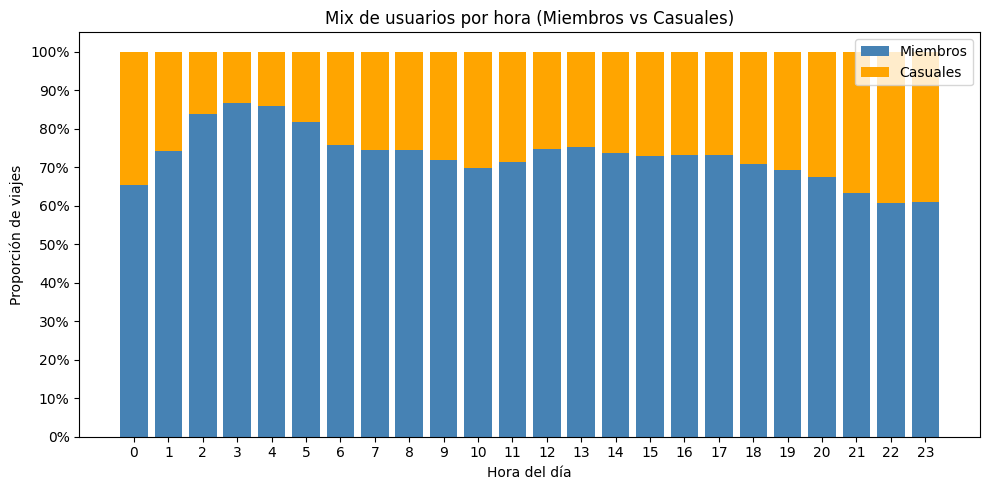

Guardado: /content/reports/figures/mix_member_por_hora_stacked.png


In [20]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# --- Asegurar columnas ---
if "trip_hour" not in df.columns:
    if "ts_hour" in df.columns:
        df["ts_hour"] = pd.to_datetime(df["ts_hour"], errors="coerce").dt.floor("H")
        df["trip_hour"] = df["ts_hour"].dt.hour
    else:
        raise ValueError("Falta 'trip_hour' y no hay 'ts_hour' para derivarlo.")

if "rides_member" not in df.columns:
    df["rides_member"] = 0
if "rides_casual" not in df.columns:
    df["rides_casual"] = 0
if "rides" not in df.columns:
    df["rides"] = df["rides_member"].fillna(0) + df["rides_casual"].fillna(0)

# --- Agregación ---
mix = (
    df.groupby("trip_hour")[["rides_member", "rides_casual", "rides"]]
      .sum()
      .reset_index()
      .sort_values("trip_hour")
)

# Evitar división por cero
den = mix["rides"].replace(0, np.nan)
mix["pct_member"] = mix["rides_member"] / den
mix["pct_casual"] = mix["rides_casual"] / den

# --- Plot stacked bar ---
plt.figure(figsize=(10, 5))
plt.bar(
    mix["trip_hour"],
    mix["pct_member"],
    label="Miembros",
    color="steelblue"
)
plt.bar(
    mix["trip_hour"],
    mix["pct_casual"],
    bottom=mix["pct_member"],
    label="Casuales",
    color="orange"
)

plt.title("Mix de usuarios por hora (Miembros vs Casuales)")
plt.xlabel("Hora del día")
plt.ylabel("Proporción de viajes")
plt.xticks(np.arange(0, 24, 1))
plt.yticks(np.linspace(0, 1, 11), ["{:.0%}".format(x) for x in np.linspace(0, 1, 11)])
plt.legend()
plt.tight_layout()

# --- Guardado ---
out_dir = Path("./reports/figures")
out_dir.mkdir(parents=True, exist_ok=True)
out = out_dir / "mix_member_por_hora_stacked.png"
plt.savefig(out, dpi=160)
plt.show()

print("Guardado:", out.resolve())


Usuarios miembros son la base estructural del sistema, sosteniendo la mayoría de los viajes en horarios laborales.

Usuarios casuales tienen un rol complementario, con picos relativos en horas no laborales y en la noche, reflejando un patrón más recreativo.

Este hallazgo es útil para:

Estrategias de pricing y marketing: reforzar membresías en horas laborales, y tal vez promociones de “casual” para fines de semana/noches.

Planificación operativa: en la noche se requiere menos capacidad total, pero con mayor atención a viajes casuales (turismo, ocio).

# Rides en pico vs no pico · Laboral vs Fin de semana


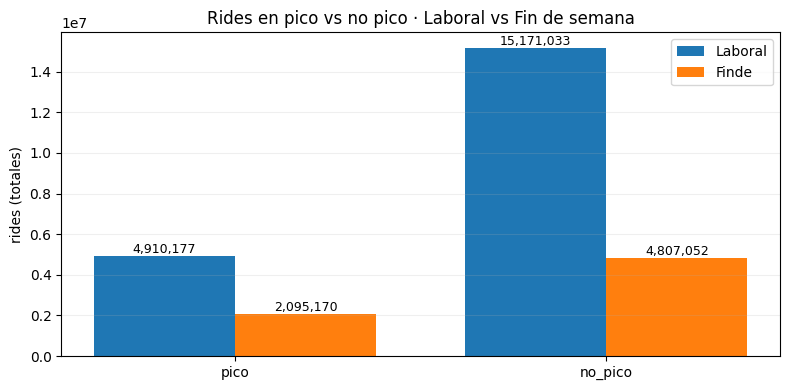

Guardado: /content/reports/figures/pico_vs_no_pico_laboral_finde.png

Tabla fuente:
 tipo       Finde   Laboral
grupo                     
pico     2095170   4910177
no_pico  4807052  15171033


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- columnas mínimas / derivaciones ---
if "trip_hour" not in df.columns:
    df["ts_hour"] = pd.to_datetime(df["ts_hour"], errors="coerce").dt.floor("H")
    df["trip_hour"] = df["ts_hour"].dt.hour

if "is_weekend" not in df.columns:
    df["is_weekend"] = df["ts_hour"].dt.dayofweek >= 5   # True sáb-dom

if "rides" not in df.columns:
    raise ValueError("Falta 'rides'.")

# Ventanas de pico (editables)
peak_blocks = [(7, 9), (17, 19)]
def in_blocks(h, blocks):
    return any(lo <= h <= hi for lo, hi in blocks)

df["is_peak"] = df["trip_hour"].apply(lambda h: in_blocks(h, peak_blocks))

# Agregado por (laboral/finde) x (pico/no-pico)
g = (df
     .groupby(["is_weekend","is_peak"])["rides"].sum()
     .reset_index())

# Pivot para tener columnas por tipo de día y filas por categoría 'pico/no_pico'
g["tipo"] = g["is_weekend"].map({False:"Laboral", True:"Finde"})
g["grupo"] = g["is_peak"].map({True:"pico", False:"no_pico"})
pv = g.pivot(index="grupo", columns="tipo", values="rides").reindex(index=["pico","no_pico"])
pv = pv.fillna(0)

# --- Plot: barras agrupadas ---
groups = pv.index.tolist()              # ["pico","no_pico"]
tipos   = ["Laboral","Finde"]
x = np.arange(len(groups))              # posiciones base
width = 0.38

plt.figure(figsize=(8,4))
for i, tipo in enumerate(tipos):
    plt.bar(x + (i-0.5)*width, pv[tipo].values, width, label=tipo)

plt.xticks(x, groups)
plt.title("Rides en pico vs no pico · Laboral vs Fin de semana")
plt.ylabel("rides (totales)")
plt.legend()
plt.grid(axis="y", alpha=0.2)

# Anotaciones arriba de cada barra
for i, tipo in enumerate(tipos):
    for xi, val in zip(x + (i-0.5)*width, pv[tipo].values):
        plt.text(xi, val, f"{int(val):,}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
out = Path("./reports/figures") / "pico_vs_no_pico_laboral_finde.png"
out.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out, dpi=160)
plt.show()
print("Guardado:", out.resolve())
print("\nTabla fuente:\n", pv.astype(int))


El sistema Blue Bikes se usa principalmente en días laborales, con un fuerte volumen en horas no pico (15M+) además de los tradicionales picos de commuting.

Los fines de semana aportan alrededor de un 30% del total de viajes, con un patrón más distribuido y menos ligado a los horarios de oficina.

Esto confirma el doble rol del sistema:

Laboral → transporte de commuting y movilidad urbana flexible.

Recreativo → uso más disperso en fines de semana.

En la operación, esto implica que la redistribución de bicicletas debe considerar:

Mayor refuerzo en días laborales durante los picos.

Estrategias de disponibilidad en fines de semana enfocadas en zonas recreativas o turísticas.

# Round trips (%) por fin de semana

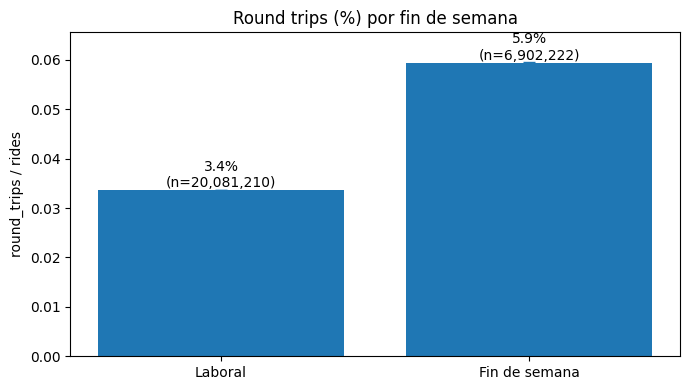

Guardado: /content/reports/figures/roundtrips_weekend.png
        label  round_trips    rides pct_rt pct_lo pct_hi
      Laboral       675962 20081210  3.37%  3.36%  3.37%
Fin de semana       410142  6902222  5.94%  5.92%  5.96%


In [23]:
# Round trips (%) por fin de semana — robusto y con anotaciones
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Asegurar columnas necesarias ---
# is_weekend: acepta bool o 0/1; si no existe, lo derivamos desde ts_hour
if "is_weekend" not in df.columns:
    if "ts_hour" in df.columns:
        _ts = pd.to_datetime(df["ts_hour"], errors="coerce")
        df["is_weekend"] = _ts.dt.dayofweek >= 5   # True sáb-dom
    else:
        raise ValueError("Falta 'is_weekend' y no hay 'ts_hour' para derivarlo.")

# round_trips: si no existe, lo creamos en 0 (mejor que romper)
if "round_trips" not in df.columns:
    df["round_trips"] = 0

# rides: si no existe, lo derivamos de rides_member + rides_casual (si están)
if "rides" not in df.columns:
    if {"rides_member","rides_casual"}.issubset(df.columns):
        df["rides"] = df["rides_member"].fillna(0) + df["rides_casual"].fillna(0)
    else:
        raise ValueError("Falta 'rides' y no se puede derivar de 'rides_member'+'rides_casual'.")

# Normalizar tipo de is_weekend (por si viene como 0/1)
if df["is_weekend"].dtype != bool:
    df["is_weekend"] = df["is_weekend"].astype(bool)

# --- Agregación ---
rt = (
    df.groupby("is_weekend")[["round_trips", "rides"]]
      .sum()
      .reset_index()
      .sort_values("is_weekend")
)

# % round trips
den = rt["rides"].replace(0, np.nan)
rt["pct_rt"] = rt["round_trips"] / den

# (Opcional) Intervalo de confianza 95% (aprox. normal para binomial)
# p ± 1.96 * sqrt(p*(1-p)/n)
p = rt["pct_rt"].to_numpy()
n = rt["rides"].to_numpy().astype(float)
se = np.sqrt(np.clip(p*(1-p)/np.maximum(n, 1.0), 0, None))
rt["pct_lo"] = p - 1.96*se
rt["pct_hi"] = p + 1.96*se

# Etiquetas legibles
rt["label"] = rt["is_weekend"].map({False: "Laboral", True: "Fin de semana"})

# --- Plot ---
plt.figure(figsize=(7, 4))
bars = plt.bar(rt["label"], rt["pct_rt"])

# Barras de error (IC 95%) — opcional; comenta si no las quieres
yerr = np.vstack([rt["pct_rt"] - rt["pct_lo"], rt["pct_hi"] - rt["pct_rt"]])
plt.errorbar(rt["label"], rt["pct_rt"], yerr=yerr, fmt="none", capsize=4)

plt.title("Round trips (%) por fin de semana")
plt.ylabel("round_trips / rides")
plt.ylim(0, max(0.001, float(rt["pct_hi"].max()) * 1.10))  # pequeño margen arriba

# Anotar porcentaje y n
for b, pct, n_rides in zip(bars, rt["pct_rt"], rt["rides"]):
    y = b.get_height()
    txt = f"{pct*100:0.1f}%\n(n={int(n_rides):,})"
    plt.text(b.get_x() + b.get_width()/2, y, txt, ha="center", va="bottom")

plt.tight_layout()

# --- Guardado ---
out_dir = Path("./reports/figures")
out_dir.mkdir(parents=True, exist_ok=True)
out = out_dir / "roundtrips_weekend.png"
plt.savefig(out, dpi=160)
plt.show()

print("Guardado:", out.resolve())
print(rt[["label","round_trips","rides","pct_rt","pct_lo","pct_hi"]]
      .to_string(index=False, formatters={
          "pct_rt": "{:.2%}".format, "pct_lo": "{:.2%}".format, "pct_hi": "{:.2%}".format
      }))


El sistema Blue Bikes se usa de forma distinta según el tipo de día:

En laborales, domina el uso funcional de transporte (ida → destino distinto).

En fines de semana, aumenta el uso recreativo (ida y vuelta a la misma estación).

Este hallazgo puede ser útil para:

Planificación de estaciones turísticas o de ocio (fines de semana, más round trips).

Estrategias de membresía y precios diferenciados para capturar mejor la demanda recreativa de sábados y domingos.

Redistribución de bicicletas más orientada a “ida y vuelta” en fines de semana, con menos riesgo de desequilibrio de estaciones.

# Top estaciones por demanda y variabilidad intra-día

                                          station_name  rides_total  variabilidad_horaria    rides_mean  \
482                       MIT at Mass Ave / Amherst St       608086          18711.665213  25336.916667   
189              Central Square at Mass Ave / Essex St       470020          13170.102778  19584.166667   
391                Harvard Square at Mass Ave/ Dunster       388100          11725.267586  16170.833333   
479                    MIT Pacific St at Purrington St       310869           7408.396237  12952.875000   
480            MIT Stata Center at Vassar St / Main St       310345          13016.008680  12931.041667   
52                                  Ames St at Main St       302501          12726.231161  12604.208333   
481                                      MIT Vassar St       291962           7526.356130  12165.083333   
198        Charles Circle - Charles St at Cambridge St       278244           7084.695851  11593.500000   
226  Christian Science Plaza - Massac

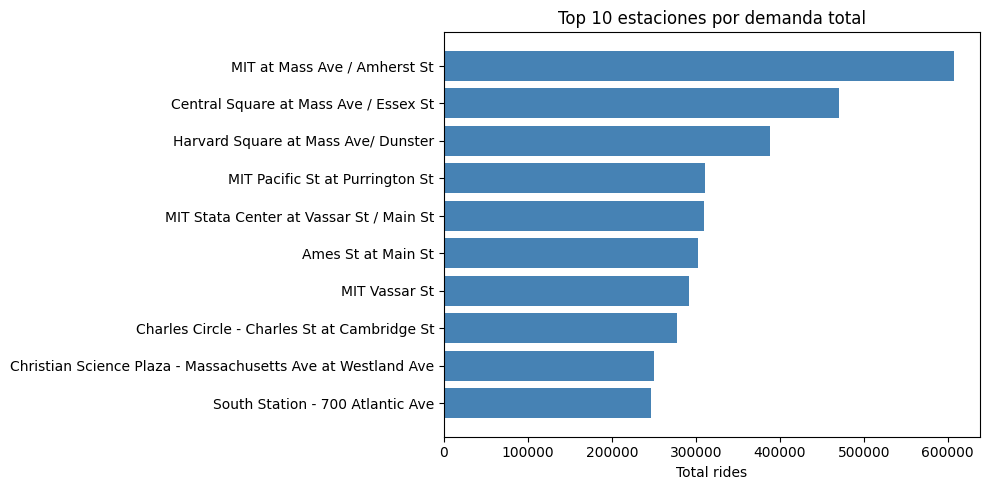

Guardado: /content/reports/figures/top10_estaciones_rides.png


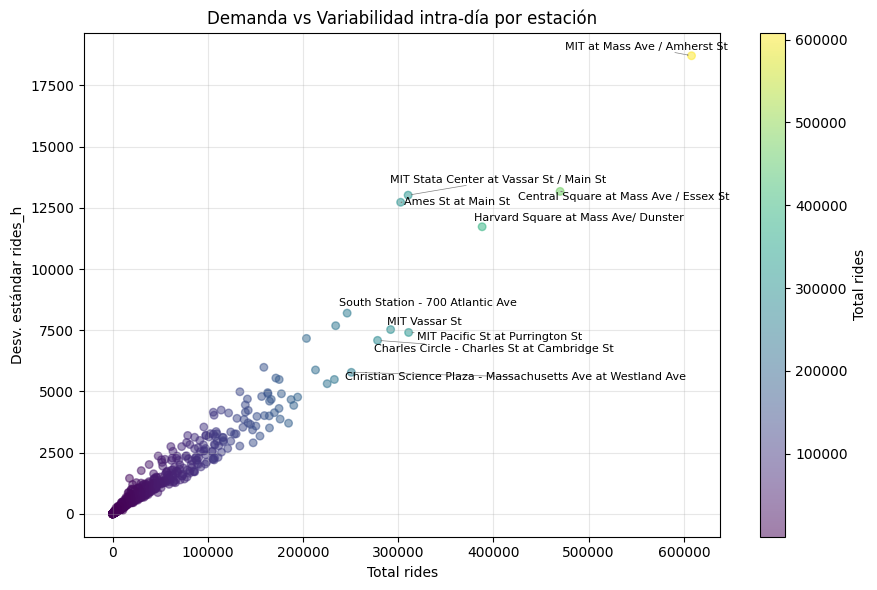

In [26]:
# Top estaciones por demanda y variabilidad intra-día
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Normalizar nombres ---
df = df.rename(columns={"start_station_name": "station_name"}).copy()

# --- Asegurar columnas necesarias ---
if not {"station_name", "trip_hour", "rides"}.issubset(df.columns):
    raise ValueError(f"Columnas disponibles: {list(df.columns)}")

# --- Base agregada: suma de rides por estación y hora ---
base = (
    df.groupby(["station_name", "trip_hour"])["rides"]
      .sum()
      .reset_index(name="rides_h")
)

# --- Agregación por estación ---
agg_station = (
    base.groupby("station_name")
        .agg(
            rides_total=("rides_h", "sum"),
            variabilidad_horaria=("rides_h", "std"),
            rides_mean=("rides_h", "mean"),
            horas_registradas=("rides_h", "count")
        )
        .reset_index()
        .sort_values("rides_total", ascending=False)
)

# --- Top 10 ---
top10 = agg_station.head(10)
print(top10)

# --- Plot 1: barras por demanda total ---
plt.figure(figsize=(10, 5))
plt.barh(top10["station_name"], top10["rides_total"], color="steelblue")
plt.title("Top 10 estaciones por demanda total")
plt.xlabel("Total rides")
plt.gca().invert_yaxis()
plt.tight_layout()

out_dir = Path("./reports/figures")
out_dir.mkdir(parents=True, exist_ok=True)
out1 = out_dir / "top10_estaciones_rides.png"
plt.savefig(out1, dpi=160)
plt.show()
print("Guardado:", out1.resolve())

!pip install adjustText
from adjustText import adjust_text

plt.figure(figsize=(9,6))
plt.scatter(agg_station["rides_total"], agg_station["variabilidad_horaria"],
            alpha=0.5, s=30, c=agg_station["rides_total"], cmap="viridis")

plt.title("Demanda vs Variabilidad intra-día por estación")
plt.xlabel("Total rides")
plt.ylabel("Desv. estándar rides_h")
plt.grid(True, alpha=0.3)

# Etiquetar solo top10
texts = []
for _, row in top10.iterrows():
    texts.append(
        plt.text(row["rides_total"], row["variabilidad_horaria"],
                 row["station_name"], fontsize=8)
    )

adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5))

plt.colorbar(label="Total rides")
plt.tight_layout()
plt.show()



Existe una proporcionalidad natural: más viajes totales → más variabilidad horaria.

El sistema Blue Bikes tiene un núcleo de estaciones críticas (MIT, Harvard, South Station) que concentran y concentran la variabilidad.

Estas estaciones deberían ser prioridad en:

Planificación de flotas.

Colocación de más docks.

Análisis de horarios pico.

# Ventanas de servicio (horas valle con P20)

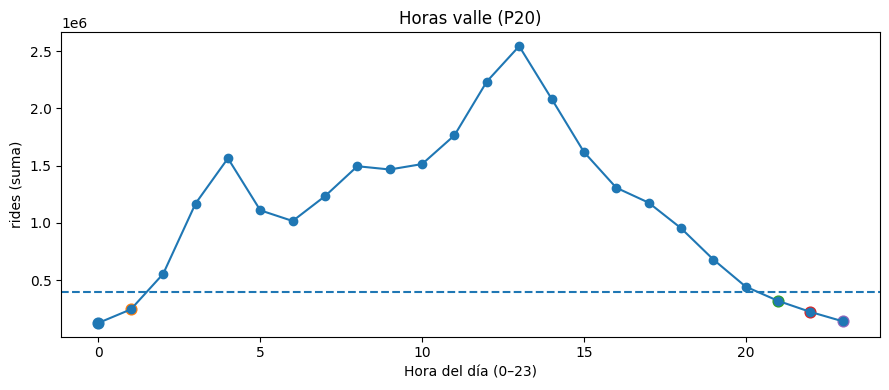

Guardado: /content/reports/figures/horas_valle_p20.png

Horas valle detectadas:
 trip_hour  rides_h
         0   126442
         1   244434
        21   318715
        22   222118
        23   140259


In [27]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== Parámetros opcionales =====
station_filter = None        # ejemplo: "South Station - 700 Atlantic Ave"  |  None = toda la red
use_weekend_split = False    # True = calcula P20 por laboral/fin de semana por separado

# ===== Normalización mínima =====
if "trip_hour" not in df.columns:
    if "ts_hour" in df.columns:
        df["ts_hour"] = pd.to_datetime(df["ts_hour"], errors="coerce").dt.floor("H")
        df["trip_hour"] = df["ts_hour"].dt.hour
    else:
        raise ValueError("Falta 'trip_hour' y no hay 'ts_hour' para derivarlo.")

if "rides" not in df.columns:
    raise ValueError("Tu DataFrame no tiene la columna 'rides'.")

if "is_weekend" not in df.columns:
    if "ts_hour" in df.columns:
        df["is_weekend"] = df["ts_hour"].dt.dayofweek >= 5
    else:
        df["is_weekend"] = False

# ===== Filtro por estación (opcional) =====
df_plot = df.copy()
if station_filter:
    df_plot = df_plot[df_plot.get("start_station_name", df_plot.get("station_name","")).eq(station_filter)]

# ===== Agregación global por hora (y split opcional) =====
if use_weekend_split:
    dist = (
        df_plot.groupby(["is_weekend","trip_hour"])["rides"]
              .sum()
              .reset_index(name="rides_h")
    )
    # relleno de horas 0-23 en ambos grupos
    full_idx = pd.MultiIndex.from_product([[False, True], range(24)], names=["is_weekend","trip_hour"])
    dist = dist.set_index(["is_weekend","trip_hour"]).reindex(full_idx, fill_value=0).reset_index()
    # P20 por grupo
    p20_map = dist.groupby("is_weekend")["rides_h"].quantile(0.20).to_dict()
    dist["p20"] = dist["is_weekend"].map(p20_map)
    dist["es_valle"] = (dist["rides_h"] <= dist["p20"]).astype(int)
else:
    dist = (
        df_plot.groupby("trip_hour")["rides"]
              .sum()
              .reindex(range(24), fill_value=0)
              .reset_index(name="rides_h")
    )
    p20 = float(np.nanpercentile(dist["rides_h"], 20))
    dist["p20"] = p20
    dist["es_valle"] = (dist["rides_h"] <= p20).astype(int)

# ===== Plot (una sola figura) =====
plt.figure(figsize=(9,4))
if use_weekend_split:
    # Curvas separadas (laboral vs finde) en la misma figura
    for wknd, sub in dist.groupby("is_weekend"):
        etiqueta = "Fin de semana" if wknd else "Laboral"
        sub = sub.sort_values("trip_hour")
        plt.plot(sub["trip_hour"], sub["rides_h"], marker="o", label=etiqueta)
        # línea P20 por grupo
        plt.axhline(sub["p20"].iloc[0], linestyle="--")
else:
    plt.plot(dist["trip_hour"], dist["rides_h"], marker="o")
    plt.axhline(dist["p20"].iloc[0], linestyle="--")

# Marcar horas valle
if use_weekend_split:
    for _, sub in dist.groupby("is_weekend"):
        for hr, is_low in zip(sub["trip_hour"], sub["es_valle"]):
            if is_low == 1:
                yv = float(sub.loc[sub["trip_hour"]==hr, "rides_h"])
                plt.scatter([hr], [yv], s=60)
else:
    for hr, is_low in zip(dist["trip_hour"], dist["es_valle"]):
        if is_low == 1:
            yv = float(dist.loc[dist["trip_hour"]==hr, "rides_h"])
            plt.scatter([hr], [yv], s=60)

title_extra = f" · Estación: {station_filter}" if station_filter else ""
plt.title(f"Horas valle (P20){title_extra}")
plt.xlabel("Hora del día (0–23)")
plt.ylabel("rides (suma)")
if use_weekend_split:
    plt.legend()
plt.tight_layout()

# Guardado
out_dir = Path("./reports/figures"); out_dir.mkdir(parents=True, exist_ok=True)
fname = "horas_valle_p20_split.png" if use_weekend_split else "horas_valle_p20.png"
out = out_dir / fname
plt.savefig(out, dpi=160)
plt.show()
print("Guardado:", out.resolve())

# ===== Tabla de horas valle =====
if use_weekend_split:
    horas_valle = (dist.loc[dist["es_valle"]==1, ["is_weekend","trip_hour","rides_h"]]
                        .sort_values(["is_weekend","trip_hour"]))
    horas_valle["tipo"] = horas_valle["is_weekend"].map({False:"Laboral", True:"Fin de semana"})
    horas_valle = horas_valle[["tipo","trip_hour","rides_h"]]
else:
    horas_valle = dist.loc[dist["es_valle"]==1, ["trip_hour","rides_h"]].sort_values("trip_hour")

print("\nHoras valle detectadas:")
print(horas_valle.to_string(index=False))


El análisis de percentil P20 permite delimitar objetivamente las horas valle (madrugada y noche).

Estos horarios representan oportunidades para:

Mantenimiento preventivo de bicicletas y estaciones (menor impacto en usuarios).

Rebalanceo de flota para preparar la red antes de los picos matinales.

El sistema presenta un patrón asimétrico: la caída nocturna es más prolongada que la subida matutina, sugiriendo que la actividad decae gradualmente después del almuerzo.

# Participación de e-bikes por hora — solo último año

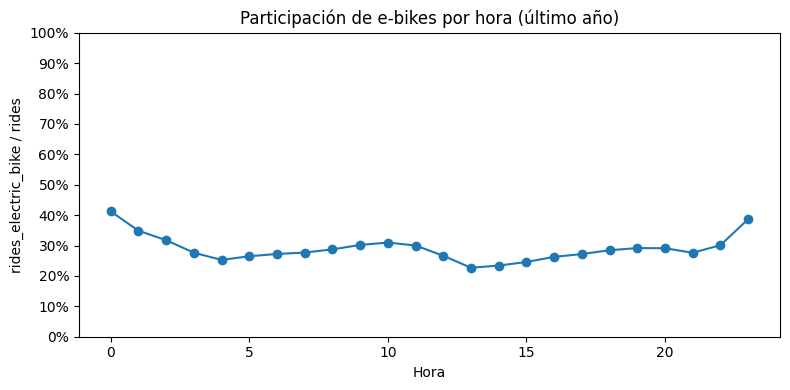

Guardado: /content/reports/figures/pct_ebike_por_hora_ultimo_anio.png
 trip_hour  rides_electric_bike  rides pct_ebike
         0                 5322  12910    41.22%
         1                14009  40172    34.87%
         2                33514 105501    31.77%
         3                62956 227744    27.64%
         4                78910 312276    25.27%
         5                61630 232745    26.48%
         6                55461 203660    27.23%
         7                62573 225911    27.70%
         8                72581 252547    28.74%
         9                79310 262480    30.22%
        10                87567 282573    30.99%
        11                99808 332508    30.02%
        12               109969 412981    26.63%
        13               107549 473849    22.70%
        14                89239 381159    23.41%
        15                68978 280319    24.61%
        16                53109 202097    26.28%
        17                42128 154856    27.20%

In [31]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===== Parámetros =====
station_filter   = None      # p.ej.: "South Station - 700 Atlantic Ave" | None = toda la red
use_weekend_split = False    # True: curvas separadas laboral vs fin de semana
rolling_smooth    = 0        # 0 = sin suavizado; p.ej. 3 para suavizar
last_n_years      = 1        # filtrar último N años

# ===== Normalización mínima =====
# Derivar trip_hour y ts_hour si hace falta
if "ts_hour" not in df.columns and "trip_hour" in df.columns:
    # si no hay ts_hour, lo intentamos derivar desde started_at/algún timestamp si existe
    for cand in ["started_at_local","started_at","timestamp","date_hour","ts"]:
        if cand in df.columns:
            df["ts_hour"] = pd.to_datetime(df[cand], errors="coerce").dt.floor("H")
            break
if "ts_hour" in df.columns:
    df["ts_hour"] = pd.to_datetime(df["ts_hour"], errors="coerce").dt.floor("H")

if "trip_hour" not in df.columns:
    if "ts_hour" in df.columns:
        df["trip_hour"] = df["ts_hour"].dt.hour
    else:
        raise ValueError("Falta 'trip_hour' y no hay 'ts_hour' para derivarlo.")

# Alias común: rides_electric → rides_electric_bike
if "rides_electric_bike" not in df.columns and "rides_electric" in df.columns:
    df = df.rename(columns={"rides_electric": "rides_electric_bike"})

# Columnas mínimas
if "rides_electric_bike" not in df.columns:
    df["rides_electric_bike"] = 0
if "rides" not in df.columns:
    if {"rides_member","rides_casual"}.issubset(df.columns):
        df["rides"] = df["rides_member"].fillna(0) + df["rides_casual"].fillna(0)
    else:
        raise ValueError("Falta 'rides' y no se puede derivar.")

# weekend flag si se necesita
if use_weekend_split and "is_weekend" not in df.columns:
    if "ts_hour" in df.columns:
        df["is_weekend"] = df["ts_hour"].dt.dayofweek >= 5
    else:
        df["is_weekend"] = False

# ===== Filtro: ÚLTIMO AÑO =====
df_plot = df.copy()

if "ts_hour" in df_plot.columns and df_plot["ts_hour"].notna().any():
    max_ts = df_plot["ts_hour"].max()
    start_ts = max_ts - pd.DateOffset(years=last_n_years)
    df_plot = df_plot[df_plot["ts_hour"] >= start_ts]
elif "trip_year" in df_plot.columns:
    # fallback: usa el año más reciente disponible
    df_plot = df_plot[df_plot["trip_year"] == df_plot["trip_year"].max()]
else:
    raise ValueError("No encuentro 'ts_hour' ni 'trip_year' para limitar al último año.")

# ===== Filtro por estación (opcional) =====
if station_filter:
    if "start_station_name" in df_plot.columns:
        df_plot = df_plot[df_plot["start_station_name"] == station_filter]
    elif "station_name" in df_plot.columns:
        df_plot = df_plot[df_plot["station_name"] == station_filter]

# ===== Agregación =====
if use_weekend_split:
    eb = (
        df_plot.groupby(["is_weekend","trip_hour"])[["rides_electric_bike","rides"]]
              .sum()
              .reset_index()
    )
    full_idx = pd.MultiIndex.from_product([[False, True], range(24)], names=["is_weekend","trip_hour"])
    eb = eb.set_index(["is_weekend","trip_hour"]).reindex(full_idx, fill_value=0).reset_index()
    eb["pct_ebike"] = eb["rides_electric_bike"] / eb["rides"].replace(0, np.nan)
else:
    eb = (
        df_plot.groupby("trip_hour")[["rides_electric_bike","rides"]]
              .sum()
              .reindex(range(24), fill_value=0)
              .reset_index()
    )
    eb["pct_ebike"] = eb["rides_electric_bike"] / eb["rides"].replace(0, np.nan)

# Suavizado opcional
ycol = "pct_ebike"
if rolling_smooth and rolling_smooth > 1:
    if use_weekend_split:
        eb["pct_ebike_smooth"] = (
            eb.groupby("is_weekend")["pct_ebike"]
              .transform(lambda s: s.rolling(rolling_smooth, center=True, min_periods=1).mean())
        )
    else:
        eb["pct_ebike_smooth"] = eb["pct_ebike"].rolling(rolling_smooth, center=True, min_periods=1).mean()
    ycol = "pct_ebike_smooth"

# ===== Plot =====
plt.figure(figsize=(8,4))
if use_weekend_split:
    for wknd, sub in eb.groupby("is_weekend"):
        etiqueta = "Fin de semana" if wknd else "Laboral"
        sub = sub.sort_values("trip_hour")
        plt.plot(sub["trip_hour"], sub[ycol], marker="o", label=etiqueta)
    plt.legend()
else:
    plt.plot(eb["trip_hour"], eb[ycol], marker="o")

plt.title("Participación de e-bikes por hora (último año)")
plt.xlabel("Hora")
plt.ylabel("rides_electric_bike / rides")
plt.yticks(np.linspace(0,1,11), ["{:.0%}".format(x) for x in np.linspace(0,1,11)])
plt.tight_layout()

# Guardar
out_dir = Path("./reports/figures"); out_dir.mkdir(parents=True, exist_ok=True)
fname = "pct_ebike_por_hora_ultimo_anio_split.png" if use_weekend_split else "pct_ebike_por_hora_ultimo_anio.png"
out = out_dir / fname
plt.savefig(out, dpi=160)
plt.show()
print("Guardado:", out.resolve())

# (Opcional) tabla
print(eb[["trip_hour"] + (["is_weekend"] if use_weekend_split else []) + ["rides_electric_bike","rides","pct_ebike"]]
      .to_string(index=False, formatters={"pct_ebike":"{:.2%}".format}))


Las e-bikes representan entre 1/4 y 1/3 de los viajes totales, con picos relativos en la noche y madrugada.

Esto sugiere que los usuarios tienden a elegir e-bikes en contextos de menor disponibilidad o cuando buscan trayectos más rápidos/menos exigentes físicamente.

En cambio, durante las horas de commuting laboral, las bicicletas mecánicas siguen dominando la movilidad.

Implica que la planificación de flota debería:

Asegurar suficiente disponibilidad de e-bikes en horarios nocturnos, donde tienen más peso relativo.

Evaluar si existe una demanda contenida en horas laborales que podría captarse con más estaciones equipadas con e-bikes.